In [3]:
!conda install seaborn -y

Solving environment: done

## Package Plan ##

  environment location: /Users/michael/anaconda3

  added / updated specs:
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    statsmodels-0.10.1         |   py37heacc8b8_0         8.8 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         8.8 MB

The following NEW packages will be INSTALLED:

  patsy              conda-forge/noarch::patsy-0.5.1-py_0
  seaborn            conda-forge/noarch::seaborn-0.9.0-py_1
  statsmodels        conda-forge/osx-64::statsmodels-0.10.1-py37heacc8b8_0



statsmodels-0.10.1   | 8.8 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [4]:
import numpy as np
import xarray
import metpy
from os import path as op
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyresample import image, geometry
import seaborn as sns
import dask
sns.set(style="darkgrid")

DATA_PATH='goesdata'
%matplotlib inline

In [5]:
rad_data_file = 'OR_ABI-L1b-RadF-M6C07_G17_s20191030000339_e20191030009417_c20191030009441.nc'

In [6]:
G17C07= xarray.open_dataset(op.join(DATA_PATH,rad_data_file))

In [8]:
G17C07.keys()

KeysView(<xarray.Dataset>
Dimensions:                                           (band: 1, num_star_looks: 24, number_of_image_bounds: 2, number_of_time_bounds: 2, x: 5424, y: 5424)
Coordinates:
    t                                                 datetime64[ns] ...
  * y                                                 (y) float32 0.151844 ... -0.151844
  * x                                                 (x) float32 -0.151844 ... 0.151844
    y_image                                           float32 ...
    x_image                                           float32 ...
    band_id                                           (band) int8 ...
    band_wavelength                                   (band) float32 ...
    t_star_look                                       (num_star_looks) datetime64[ns] ...
    band_wavelength_star_look                         (num_star_looks) float32 ...
Dimensions without coordinates: band, num_star_looks, number_of_image_bounds, number_of_time_bounds
Data va

In [9]:
G17C07['goes_imager_projection']

<xarray.DataArray 'goes_imager_projection' ()>
array(-2147483647, dtype=int32)
Coordinates:
    t        datetime64[ns] ...
    y_image  float32 ...
    x_image  float32 ...
Attributes:
    long_name:                       GOES-R ABI fixed grid projection
    grid_mapping_name:               geostationary
    perspective_point_height:        35786023.0
    semi_major_axis:                 6378137.0
    semi_minor_axis:                 6356752.31414
    inverse_flattening:              298.2572221
    latitude_of_projection_origin:   0.0
    longitude_of_projection_origin:  -137.0
    sweep_angle_axis:                x

In [10]:
# Generate cartopy projection object with metpy parser
# NOTE: Don't re-run this cell after it has run or it won't work.
dat17C07 = G17C07.metpy.parse_cf('Rad')

In [11]:
# Geostationary projections
geos17 = dat17C07.metpy.cartopy_crs

cartopy_extent_goes17 = geos17.x_limits + geos17.y_limits
pyresample_extent_goes17 = (cartopy_extent_goes17[0],
                            cartopy_extent_goes17[2],
                            cartopy_extent_goes17[1],
                            cartopy_extent_goes17[3])
goes17_params = geos17.proj4_params
rad07 = dat17C07.data

In [12]:
rad07.shape

(5424, 5424)

In [13]:
np.nanmax(rad07)
np.nanmin(rad07)


-0.0031842776

In [14]:
def normIm(im,gamma=1.0, reverse=False):
    nim = ((im-np.nanmin(im))*(im-np.nanmin(im)-np.nanmin(rad07))**(-1))
    if reverse:
        nim = (1.0-nim**(gamma))
    return nim

(-0.5, 5423.5, 5423.5, -0.5)

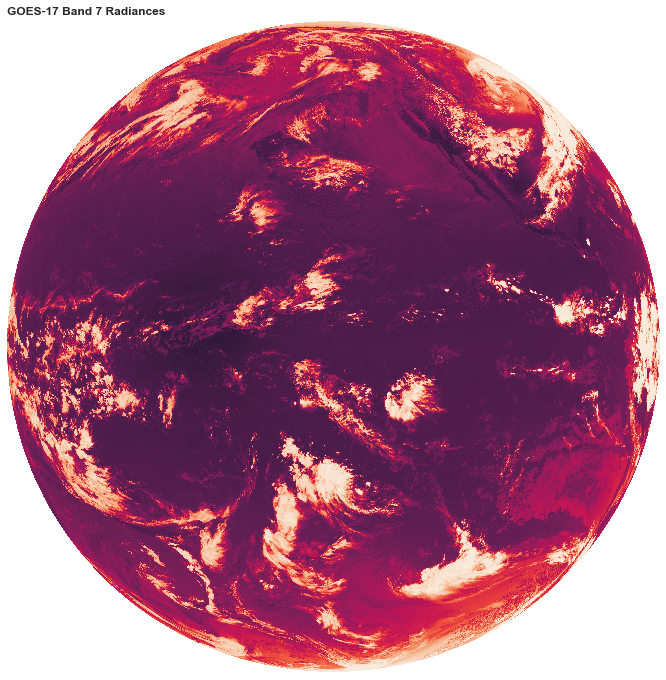

In [15]:
fig1, axes1 = plt.subplots(figsize=(12,12))

# The GOES-17 band 07
axes1.imshow(normIm(rad07,gamma=64,reverse=True))
axes1.set_title('GOES-17 Band 7 Radiances', fontweight='semibold', loc='left', fontsize=12);
axes1.axis('off')
#fig1.colorbar(dat17C07.data.ravel(), orientation='vertical')

Text(0.5, 1.0, 'GOES-17')

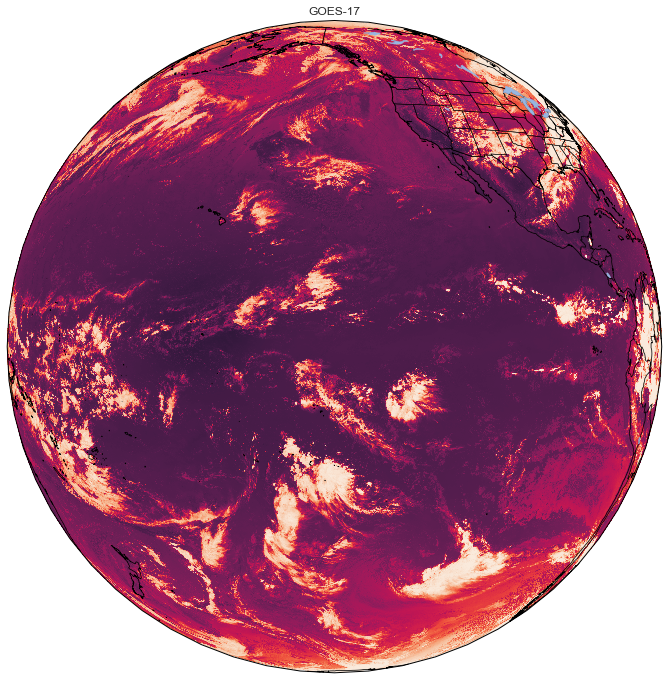

In [16]:
fig_2 = plt.figure(figsize=(12, 12))

ax1_2 = fig_2.add_subplot(1, 1, 1, projection=geos17)


## GOES 17
ax1_2.imshow(normIm(rad07,gamma=64,reverse=True), origin='upper', extent=cartopy_extent_goes17,
           transform=geos17)
ax1_2.coastlines(resolution='50m', color='black', linewidth=.75)
ax1_2.add_feature(ccrs.cartopy.feature.BORDERS, linewidth=.75)
ax1_2.add_feature(ccrs.cartopy.feature.STATES, linewidth=.5)
ax1_2.add_feature(ccrs.cartopy.feature.LAKES, linewidth=.5)
ax1_2.set_title('GOES-17')

In [17]:
dat17C07.data.max()

nan

In [18]:
pc = ccrs.PlateCarree()
mc = ccrs.Mercator()

big_box_extent_pc_cartopy = [-116, -95, -10, 10]
big_box_extent_mc = mc.transform_points(pc, 
                    np.array(big_box_extent_pc_cartopy[:2]),
                    np.array(big_box_extent_pc_cartopy[2:])).ravel()
big_box_extent_mc_cartopy = [
    big_box_extent_mc[0],
    big_box_extent_mc[3],
    big_box_extent_mc[1],
    big_box_extent_mc[4]
]
roi_extent_pc_cartopy = [-109.59326, -102.40674, 
                          8.94659, -8.94656]
roi_extent_mc = mc.transform_points(pc, 
                    np.array(roi_extent_pc_cartopy[:2]),
                    np.array(roi_extent_pc_cartopy[2:])).ravel()
roi_extent_mc_cartopy = [
    roi_extent_mc[0],
    roi_extent_mc[3],
    roi_extent_mc[1],
    roi_extent_mc[4]
]
roi_extent_mc_pyresample = [
    roi_extent_mc[0],
    roi_extent_mc[1],
    roi_extent_mc[3],
    roi_extent_mc[4]
]
print(big_box_extent_mc_cartopy)
print(roi_extent_mc_cartopy)

[-12913060.932019735, -10575351.62536099, -1111475.102852224, 1111475.1028522253]
[-12199865.897574836, -11399866.150599161, 993361.388724224, -993358.0300969948]


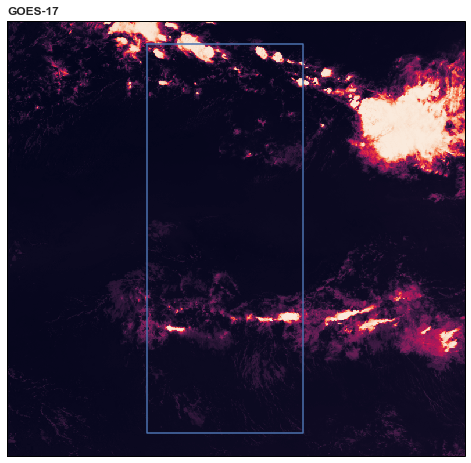

In [19]:
fig_3 = plt.figure(figsize=(15, 8))

ax_3 = fig_3.add_subplot(1, 1, 1, projection=mc)

ax_3.set_extent(big_box_extent_mc_cartopy, crs=mc)

roi_x = [roi_extent_mc_cartopy[0], 
         roi_extent_mc_cartopy[1],
         roi_extent_mc_cartopy[1],
         roi_extent_mc_cartopy[0],
         roi_extent_mc_cartopy[0]]

roi_y = [roi_extent_mc_cartopy[2], 
         roi_extent_mc_cartopy[2],
         roi_extent_mc_cartopy[3],
         roi_extent_mc_cartopy[3],
         roi_extent_mc_cartopy[2]]
# GOES17
ax_3.imshow(normIm(rad07,gamma=64,reverse=True), origin='upper',
           extent=cartopy_extent_goes17,
           transform=geos17,
           interpolation='none')
ax_3.add_feature(ccrs.cartopy.feature.STATES)
ax_3.coastlines(resolution='50m', color='black', linewidth=.75)
ax_3.add_feature(ccrs.cartopy.feature.BORDERS, linewidth=.75)
ax_3.add_feature(ccrs.cartopy.feature.STATES, linewidth=.5)
ax_3.add_feature(ccrs.cartopy.feature.LAKES, linewidth=.5)
ax_3.set_title('GOES-17', loc='left', fontweight='bold')
ax_3.plot(roi_x, roi_y,'b-')

In [20]:
norm_image_ma = np.ma.masked_array(rad07)
goes17_params = geos17.proj4_params
# Float conversion needed and re-ordering of extent to match pyresample form [x_min, y_min, x_max, y_max] 
goes17_area = geometry.AreaDefinition('GOES-17', 'Full Disk',
                                'GOES-17', goes17_params,
                               rad07.shape[1], rad07.shape[0],
                              pyresample_extent_goes17)
area_mc_def = geometry.AreaDefinition('areaTest', 'Equator-ROW', 'areaTest',
                                  mc.proj4_params,
                                    500, 200,
                                   roi_extent_mc_pyresample)
geos17_con_nn = image.ImageContainerNearest(norm_image_ma, 
                                            goes17_area, 
                                            radius_of_influence=50000)

# Here we are using pyresample for the remapping
area_mc_con_nn = geos17_con_nn.resample(area_mc_def)
image_mc_17 = area_mc_con_nn.image_data



Text(0.0, 1.0, 'GOES-17')

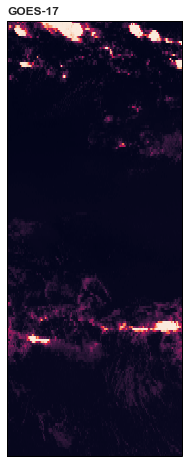

In [64]:
fig_4 = plt.figure(figsize=(15, 8))

ax_4 = fig_4.add_subplot(1, 1, 1, projection=mc)

ax_4.set_extent(roi_extent_mc_cartopy, crs=mc)


# GOES17
ax_4.imshow(normIm(image_mc_17,gamma=64,reverse=True), origin='upper',
           extent=roi_extent_mc_cartopy,
           transform=mc,
           interpolation='none')
ax_4.set_title('GOES-17', loc='left', fontweight='bold')


In [25]:
planck_fk1 = float(G17C07['planck_fk1'].data)
planck_fk2 = float(G17C07['planck_fk2'].data) 
planck_bc1 = float(G17C07['planck_bc1'].data)                       
planck_bc2 = float(G17C07['planck_bc2'].data)     


In [26]:
def Rad2BT(rad, planck_fk1, planck_fk2, planck_bc1, planck_bc2):
    """Radiances to Brightness Temprature (using black body equation)"""
    invRad = np.array(rad)**(-1)
    arg = (invRad*planck_fk1) + 1.0
    T = (- planck_bc1+(planck_fk2 * (np.log(arg)**(-1))) )*(1/planck_bc2) 
    return T

In [27]:
# Map all brightnesses to temps first
T = Rad2BT(image_mc_17, planck_fk1, planck_fk2, planck_bc1, planck_bc2)

In [29]:
# Then take there mean. That is different
T.mean()

295.40356

In [30]:
# Then average the radiances 
image_mc_17.mean()

0.76250345

In [31]:
# And then mapping this to a BT
Rad2BT(image_mc_17.mean(), planck_fk1, planck_fk2, planck_bc1, planck_bc2)

296.1893765948433

## Given loaded data, and a target extent return ROI array

In [33]:
G17C07.platform_ID

'G17'

In [34]:
def goes_rad_2_roi(loaded_goes,target_extent,target_rows,target_cols,cartopy_proj, radius_of_influence=50000):
    """Function that returns an extent"""
    dat = loaded_goes.metpy.parse_cf('Rad')
    geos_crs = dat.metpy.cartopy_crs
    cartopy_source_extent = geos_crs.x_limits + geos_crs.y_limits
    pyresample_source_extent = (cartopy_source_extent[0],
                                cartopy_source_extent[2],
                                cartopy_source_extent[1],
                                cartopy_source_extent[3])
    rad = dat.data
    proj4_source_params = geos_crs.proj4_params
    source_area = geometry.AreaDefinition('GOES-1X', 'Full Disk',
                                'GOES-1X', proj4_source_params,
                                rad.shape[1], rad.shape[0],
                                pyresample_source_extent)
    area_target_def = geometry.AreaDefinition('areaTest', 'Target Region', 'areaTest',
                                    cartopy_proj.proj4_params,
                                    target_rows, target_cols,
                                    target_extent)
    geos_con_nn = image.ImageContainerNearest(norm_image_ma, 
                                            source_area, 
                                            radius_of_influence=radius_of_influence)

    # Here we are using pyresample for the remapping
    area_proj_con_nn = geos_con_nn.resample(area_mc_def)
    return area_proj_con_nn.image_data
        

In [35]:
pc = ccrs.PlateCarree()
mc = ccrs.Mercator()

# Convert extent from pc to mc (both cylindrical projections)
target_extent_pc_cartopy = [-109.59326, -102.40674, 
                           8.94659, -8.94656]
target_extent_mc = mc.transform_points(pc, 
                    np.array(target_extent_pc_cartopy[:2]),
                    np.array(target_extent_pc_cartopy[2:])).ravel()



target_extent_mc_pyresample = [
    target_extent_mc[0],
    target_extent_mc[1],
    target_extent_mc[3],
    target_extent_mc[4]
]
roi_rads = goes_rad_2_roi(G17C07,
               target_extent_mc_pyresample,
               500,
               200,
               mc)



In [39]:
target_extent_mc_cartopy=np.hstack([target_extent_mc[:2],target_extent_mc[3:5]])
target_extent_mc_cartopy

array([-12199865.89757484,    993361.38872422, -11399866.15059916,
         -993358.03009699])

Text(0.0, 1.0, 'GOES-17')

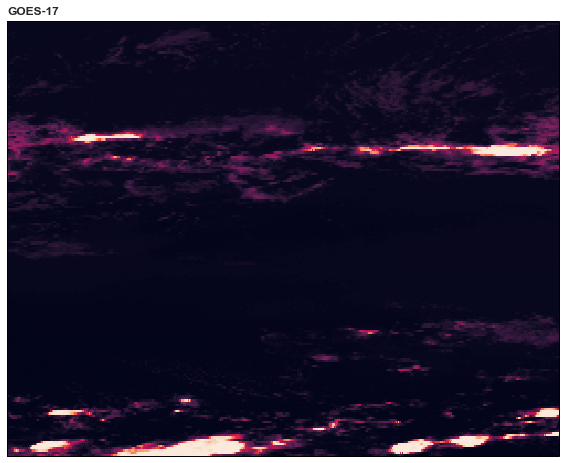

In [40]:

fig_5 = plt.figure(figsize=(15, 8))

ax_5 = fig_5.add_subplot(1, 1, 1, projection=mc)

ax_5.set_extent(target_extent_mc_cartopy, crs=mc)


# GOES17
ax_5.imshow(normIm(roi_rads,gamma=64,reverse=True), origin='upper',
           extent=target_extent_mc_cartopy,
           transform=mc,
           interpolation='none')
ax_5.set_title('GOES-17', loc='left', fontweight='bold')